In [1]:
import pandas as pd
import numpy as np
import annoy
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import keras
from keras.layers import Dense, Dropout, Flatten
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from PIL import Image
import os
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from collections import Counter 
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.applications.xception import Xception,preprocess_input
from keras.preprocessing import image
from keras.layers import Input
from keras.backend import reshape
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten,Reshape,UpSampling2D,Input,Lambda,Conv2DTranspose
from statistics import mode,mean

**IMPORT IMAGES FILE**

In [2]:
images=pd.read_csv('img_pres.csv')
images=images.drop('Unnamed: 0',axis=1)
images.rename(columns={'0':'img_id'},inplace=True)
print(images.shape)
images.head()

(105100, 1)


,img_id
0,0108775015.jpg
1,0108775044.jpg
2,0108775051.jpg
3,0110065001.jpg
4,0110065002.jpg


In [3]:
images['ids']=images['img_id'].apply(lambda x:x[1:10])
images.head()

,img_id,ids
0,0108775015.jpg,108775015
1,0108775044.jpg,108775044
2,0108775051.jpg,108775051
3,0110065001.jpg,110065001
4,0110065002.jpg,110065002


In [4]:
images['path']=images['img_id'].apply(lambda x: f"images/{x[0:3]}/{x}")

In [4]:
images.head()

,img_id,ids
0,0108775015.jpg,108775015
1,0108775044.jpg,108775044
2,0108775051.jpg,108775051
3,0110065001.jpg,110065001
4,0110065002.jpg,110065002


In [7]:
ids=images['ids'][0:5000]
ids=[int(x) for x in ids]

**IMPORT ARTICLES DATASET**

In [8]:
articles=pd.read_csv('articles.csv')
print(articles.shape)

(105542, 25)


In [9]:
articles=articles.loc[articles['article_id'].isin(ids)][['article_id','product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc']]
articles.shape

(5000, 25)

In [10]:
articles.tail(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
5060,489435015,489435,Riri sandalina,91,Sandals,Shoes,1010016,Solid,22,Yellow,...,Flats,C,Ladies Accessories,1,Ladieswear,64,Womens Shoes,1020,Shoes,Sandals with open sides and toes and crossover...
5061,489435016,489435,Riri sandalina,91,Sandals,Shoes,1010016,Solid,12,Light Beige,...,Divided Shoes,D,Divided,2,Divided,52,Divided Accessories,1020,Shoes,Sandals with open sides and toes and crossover...


**TRANSACTION DATASET**

In [11]:
transactions=pd.read_csv('transactions_train.csv')

In [12]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [13]:
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [14]:
from datetime import datetime

In [15]:
datetime.strptime(transactions.t_dat[1],'%Y-%m-%d')

datetime.datetime(2018, 9, 20, 0, 0)

In [16]:
transactions=transactions.loc[transactions['article_id'].isin(ids)][[ 'customer_id', 'article_id', 'price']]
transactions.shape

(2066572, 3)

In [17]:
transactions[transactions['price']==0]

,customer_id,article_id,price


**MIN PRICE**

In [18]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [18]:
transactions.head()

,customer_id,article_id,price
40,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,377277001,0.008458
41,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,377277001,0.008458
44,001127bffdda108579e6cb16080440e89bf1250a776c6e...,397068015,0.033881
55,002b3c0a44a22c45a8d62ea9d2b88d1a89e335f8b84003...,464277014,0.022017
56,002b3c0a44a22c45a8d62ea9d2b88d1a89e335f8b84003...,464277014,0.022017


In [19]:
pd.merge(transactions,articles,on='article_id').groupby('prod_name').agg(min)['price']

prod_name
10p Basic Terry            0.000322
10p Terry w.o. Clip        0.000102
10pk basic R socks         0.003542
10pk regular               0.001678
12p Claw                   0.000831
                             ...   
Zoe Sweater                0.005068
Zoella suede shopper       0.054729
Zoey woven dress           0.017780
Zola wide sleeve sweat     0.008288
class Jacobina studpack    0.000847
Name: price, Length: 1550, dtype: float64

**CUSTOMER PURCHASE HISTORY**

In [20]:
test_data = transactions.groupby(by="customer_id")['article_id'].agg(list).reset_index()
test_data.head(25)

,customer_id,article_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,[176209023]
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[351484002, 478646001, 351484002, 377277001, 3..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[351484002, 351484002]"
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[399061015, 399061015]"
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,[448509014]
5,00007d2de826758b65a93dd24ce629ed66842531df6699...,"[349301001, 464454004, 413707001, 351933001, 4..."
6,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,"[308154005, 400456001, 453239043, 485552003]"
7,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,"[407354008, 347200001]"
8,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,"[373506019, 478298005, 403392002, 253448002, 3..."
9,0000f2ea26b7f0a9175f428c8cf7743e9e10e193465ecd...,"[436083003, 436083003]"


In [23]:
customers_final=test_data['customer_id']

In [24]:
len(customers_final)

599594

In [25]:
embeds=pd.read_csv('similarities.csv')
embeds=embeds.set_index('path')
print(embeds.shape)
embeds.head()

(5000, 5000)


,images/010/0108775015.jpg,images/010/0108775044.jpg,images/010/0108775051.jpg,images/011/0110065001.jpg,images/011/0110065002.jpg,images/011/0110065011.jpg,images/011/0111565001.jpg,images/011/0111565003.jpg,images/011/0111586001.jpg,images/011/0111593001.jpg,...,images/048/0489217007.jpg,images/048/0489435001.jpg,images/048/0489435002.jpg,images/048/0489435009.jpg,images/048/0489435010.jpg,images/048/0489435011.jpg,images/048/0489435012.jpg,images/048/0489435014.jpg,images/048/0489435015.jpg,images/048/0489435016.jpg
path,,,,,,,,,,,,,,,,,,,,,
images/010/0108775015.jpg,1.000000,0.961681,0.974386,0.977738,0.961188,0.972273,0.941894,0.957899,0.956268,0.958372,...,0.911624,0.951709,0.951384,0.954769,0.954861,0.950637,0.955816,0.947313,0.954170,0.945386
images/010/0108775044.jpg,0.961681,1.000000,0.978197,0.958795,0.993788,0.981855,0.962285,0.958465,0.963825,0.964833,...,0.918834,0.980947,0.973577,0.976915,0.974529,0.977722,0.975748,0.953639,0.976721,0.961853
images/010/0108775051.jpg,0.974386,0.978197,1.000000,0.965839,0.975869,0.977835,0.948924,0.966358,0.962569,0.964599,...,0.924103,0.970994,0.963249,0.966562,0.967037,0.969613,0.966992,0.957639,0.967525,0.961195
images/011/0110065001.jpg,0.977738,0.958795,0.965839,1.000000,0.966312,0.983325,0.943709,0.943825,0.946089,0.949469,...,0.913624,0.958085,0.963144,0.962034,0.963686,0.957867,0.963485,0.949646,0.962482,0.949798
images/011/0110065002.jpg,0.961188,0.993788,0.975869,0.966312,1.000000,0.988004,0.962125,0.951366,0.954847,0.958376,...,0.913356,0.986873,0.980306,0.981371,0.980496,0.983150,0.981786,0.955436,0.981588,0.965257


**ITEM SIMILARITIES**

In [26]:
arts_data=articles.copy()
arts_data.set_index('article_id',inplace=True)
prod_name_enc = LabelEncoder()
group_name_enc = LabelEncoder()
index_enc = LabelEncoder()
arts_data['prod_name'] = prod_name_enc.fit_transform(arts_data['prod_name'].values.reshape(-1,1))
arts_data['product_group_name'] = group_name_enc.fit_transform(arts_data['product_group_name'].values.reshape(-1,1))
arts_data['index_name'] = index_enc.fit_transform(arts_data['index_name'].values.reshape(-1,1))

C:\Users\Convergytics\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
arts_data.head()

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,1328,253,Vest top,3,1010016,Solid,9,Black,4,...,Jersey Basic,A,6,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,1328,253,Vest top,3,1010016,Solid,10,White,3,...,Jersey Basic,A,6,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,1329,253,Vest top,3,1010017,Stripe,11,Off White,1,...,Jersey Basic,A,6,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,110065,1013,306,Bra,9,1010016,Solid,9,Black,4,...,Clean Lingerie,B,7,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,110065,1013,306,Bra,9,1010016,Solid,10,White,3,...,Clean Lingerie,B,7,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [28]:
dims = [
    'prod_name',
    'product_type_no',
    'product_group_name',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_name',
    'index_group_no',
    'section_no',
    'garment_group_no'
]
vector = np.ascontiguousarray(arts_data[dims].values, dtype=np.float32)
items = np.array(arts_data.index)
item_data = {"id":items,"vector":vector}

In [29]:
class AnnoyIndex():
    def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels   
        self.search_in_x_trees = 10
   
    def build(self, number_of_trees=200):
        self.index = annoy.AnnoyIndex(self.dimension,metric='manhattan')
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=5):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=self.search_in_x_trees)                                           
        return [self.labels[i] for i in indices]

In [30]:
index = AnnoyIndex(item_data['vector'],item_data['id'])
index.build(100)

In [31]:
dd = {"item":[],"similar_items":[]}
for x in tqdm(range(len(item_data['vector']))):
    similar_items = index.query(item_data['vector'][x])
    dd['item'].append(item_data['id'][x])
    dd['similar_items'].append(similar_items)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [32]:
item_similarities = pd.DataFrame(dd)
print(item_similarities.shape)
item_similarities.head()

(5000, 2)


,item,similar_items
0,108775015,"[108775015, 108775051, 479227020, 377277001, 3..."
1,108775044,"[108775051, 108775015, 479227020, 377277002, 3..."
2,108775051,"[108775051, 108775015, 479227020, 377277002, 3..."
3,110065001,"[110065001, 153115019, 253448001, 110065002, 1..."
4,110065002,"[110065002, 153115021, 253448002, 253448056, 1..."


In [33]:
item_similarities.to_csv('item_similarities.csv')

**CONTENT BASED RECOMMENDATION**

In [34]:
def content_recommendation(idd):
    idd = str(idd)
    name=articles[articles['article_id']==int(idd)].index.values.astype('int')
    name=articles.loc[name,'product_type_name'].item()
    path = f"images/0{idd[0:2]}/0{idd}.jpg"
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.title(str('article purchased:'+' '+idd+' '+name))
    plt.show()
    similar_items = list(item_similarities[item_similarities['item']==int(idd)]['similar_items'])[0]
    print('recommendations made:')
    _,ax = plt.subplots(1,len(similar_items),figsize=(15,10))
    for i,x in enumerate(similar_items):
        id = str(x)
        price=transactions[transactions['article_id']==x]['price'].to_list()
        price=mean(price)
        price=round(float(price),2)
        path = f"images/0{id[0:2]}/0{id}.jpg"
        img = mpimg.imread(path)
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(str(id+'  '+'INR'+str(price)))
    

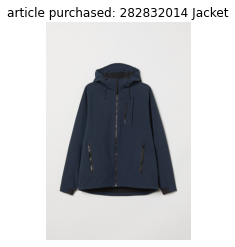

recommendations made:


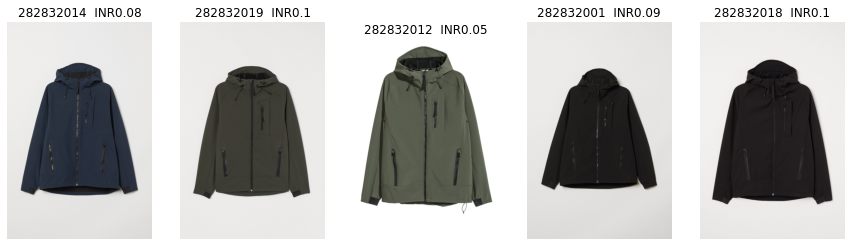

In [35]:
idd = str(282832014)
name=articles[articles['article_id']==int(idd)].index.values.astype('int')
name=articles.loc[name,'product_type_name'].item()
path = f"images/0{idd[0:2]}/0{idd}.jpg"
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.title(str('article purchased:'+' '+idd+' '+name))
plt.show()
similar_items = list(item_similarities[item_similarities['item']==int(idd)]['similar_items'])[0]
print('recommendations made:')
_,ax = plt.subplots(1,len(similar_items),figsize=(15,10))
for i,x in enumerate(similar_items):
    id = str(x)
    price=transactions[transactions['article_id']==x]['price'].to_list()
    price=mean(price)
    price=round(float(price),2)
    path = f"images/0{id[0:2]}/0{id}.jpg"
    img = mpimg.imread(path)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(str(id+'  '+'INR'+str(price)))

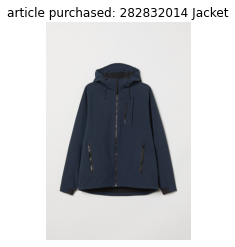

recommendations made:


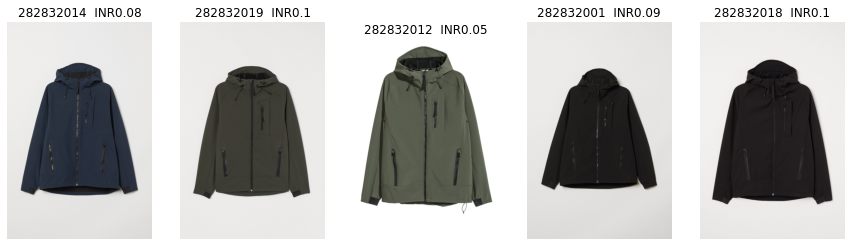

In [32]:
content_recommendation(282832014)

**IMAGE BASED**

In [36]:
def retrieve_most_similar_products(idd):
    a=articles[articles['article_id']==idd].index.values.astype('int')
    print('article purchased:',idd,articles.loc[a,'product_type_name'].item())
    a='0'+str(idd)+'.jpg'
    b=images[images['img_id']==a].index.values.astype('int')
    given_img=images.loc[images['img_id']==a]['path'].item()
    original = load_img(given_img)
    plt.imshow(original)
    plt.show()
    print("recommendations made:")
    closest_imgs = embeds[given_img].sort_values(ascending=False)[1:5+1].index.values
    closest_imgs_scores = embeds[given_img].sort_values(ascending=False)[1:5+1]
    _,ax = plt.subplots(1,len(closest_imgs),figsize=(15,10))
    for i,x in enumerate(closest_imgs):
        original = load_img(closest_imgs[i],target_size=(224,224))
        s1=slice(11,21)
        target=closest_imgs[i][s1]
        price=transactions[transactions['article_id']==int(target)]['price'].to_list()
        price=mean(price)
        price=round(float(price),2)
        ax[i].imshow(original)
        ax[i].axis('off')
        ax[i].set_title(str(target+' '+'INR'+str(price)))

article purchased: 108775015 Vest top


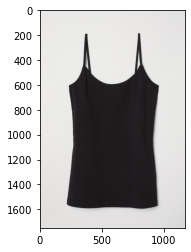

recommendations made:


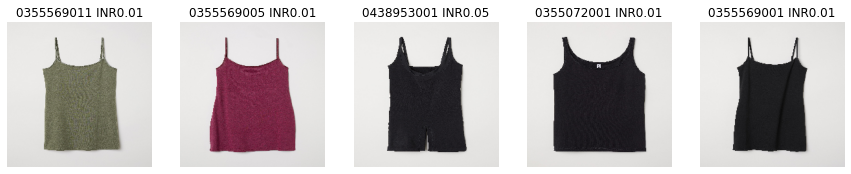

In [79]:
retrieve_most_similar_products(108775015)

**SELECTIVE RECOMMENDATION**

In [80]:
def selective(x):
    if x=='yes':
        products=list(articles['product_type_name'].unique())
        plt.tight_layout()
        plt.figure(figsize=(20,20))
        item=input()
        for i in products:
            if str(item) in i.lower().strip():
                articles_list=articles[articles['product_type_name']==i]['article_id'].to_list()
                trans_art=transactions[transactions['article_id'].isin(articles_list)][['customer_id','article_id','price']]
                trans_arts=trans_art.groupby('article_id')['customer_id'].agg(list).reset_index()
                trans_arts['counts']=trans_arts['customer_id'].apply(lambda x: len(x))
                trans_arts=trans_arts.sort_values('counts',ascending=False).head(10)
                rows=2
                for num, x in enumerate(trans_arts['article_id']):
                    a=str(x)
                    price=trans_art[trans_art['article_id']==x]['price'].to_list()
                    price=mean(price)
                    price=int(price)
                    img = Image.open(f"images/0{a[0:2]}/0{a}.jpg")
                    plt.subplot(rows,5,num+1)
                    plt.title(str(str(x)+' '+'INR'+str(price)))
                    plt.axis('off')
                    plt.imshow(img)
                    plt.subplots_adjust(wspace=0, hspace=0)

shirt


<Figure size 432x288 with 0 Axes>

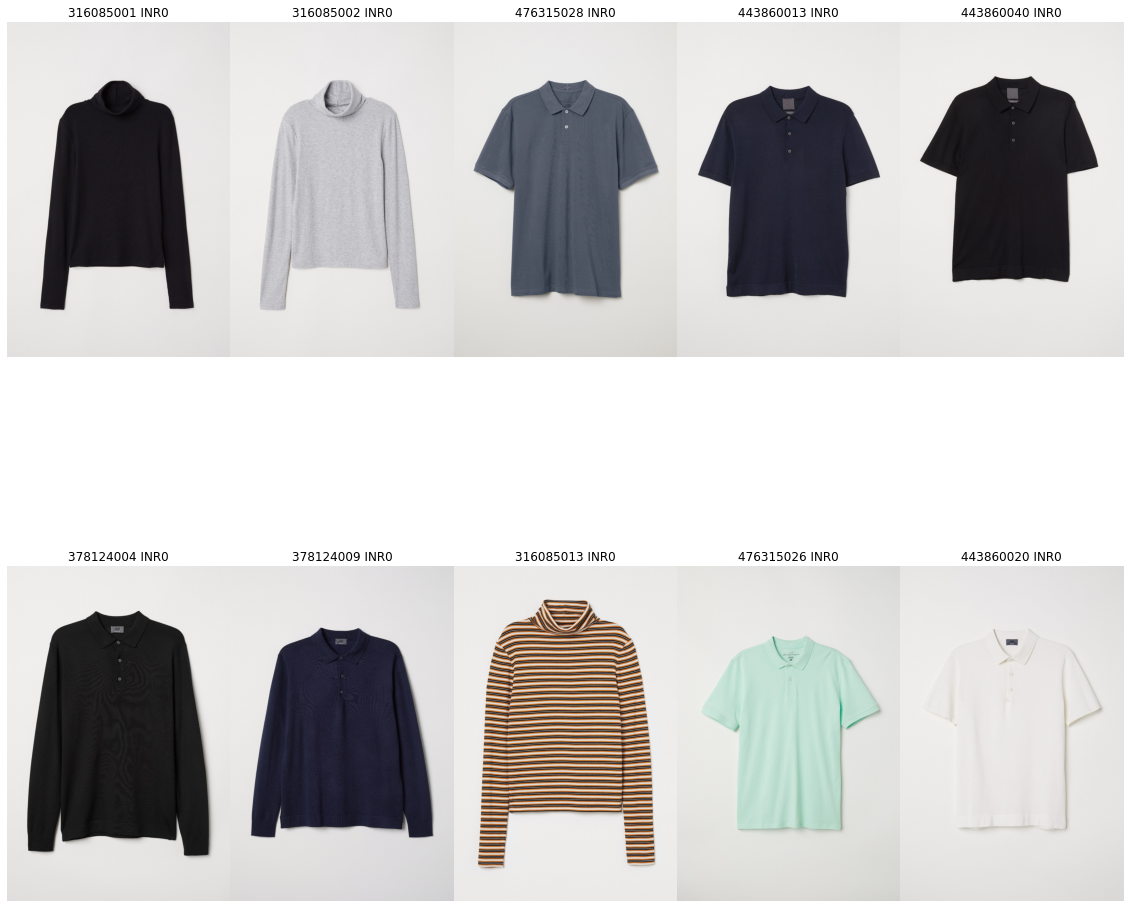

In [103]:
selective('yes')

**POPULAR RECOMMENDATION**

In [82]:
art_ladieswear=articles[articles['index_group_name']=='Ladieswear']['article_id'].to_list()
art_menswear=articles[articles['index_group_name']=='Menswear']['article_id'].to_list()
art_bc=articles[articles['index_group_name']=='Baby/Children']['article_id'].to_list()
art_divided=articles[articles['index_group_name']=='Divided']['article_id'].to_list()
art_sports=articles[articles['index_group_name']=='Sport']['article_id'].to_list()
tran_ladieswear=transactions[transactions['article_id'].isin(art_ladieswear)][['customer_id','article_id']]
tran_menswear=transactions[transactions['article_id'].isin(art_menswear)][['customer_id','article_id']]
tran_bc=transactions[transactions['article_id'].isin(art_bc)][['customer_id','article_id']]
tran_divided=transactions[transactions['article_id'].isin(art_divided)][['customer_id','article_id']]
tran_sports=transactions[transactions['article_id'].isin(art_sports)][['customer_id','article_id']]

In [83]:
freq_ladieswear=tran_ladieswear.groupby('article_id')['customer_id'].agg(list).reset_index()
freq_ladieswear['counts']=freq_ladieswear['customer_id'].apply(lambda x:len(x))
freq_ladieswear=freq_ladieswear.sort_values('counts',ascending=False).head(5)
freq_ladieswear.head()

,article_id,customer_id,counts
614,372860001,[07b0cc76dc921f034a98236199f1ca6a10c4aa3efa8d2...,31718
1084,464297007,[02334389c86031bc841c43b000006162d3bdadd0a88ac...,25025
615,372860002,[217977ee5ca3f9c5f59282e6742005ac6703c8a4e6951...,24458
44,156231001,[025b18696068392821f083b1eebb31dee1f6704f243f9...,21013
520,351484002,[1a2b2a6c18e889202811586ffb325a4b6dc48e5d19e74...,20415


In [84]:
freq_menswear=tran_menswear.groupby('article_id')['customer_id'].agg(list).reset_index()
freq_menswear['counts']=freq_menswear['customer_id'].apply(lambda x:len(x))
freq_menswear=freq_menswear.sort_values('counts',ascending=False).head(5)
freq_menswear.head()

,article_id,customer_id,counts
66,301227002,[26ba9985a9d91a1da5ccb6a94c2df9d441ad6fbe6d97a...,4219
626,452818001,[30bf75ef104f1be19da6daf971920bb00835787400c3f...,3178
374,397068015,[001127bffdda108579e6cb16080440e89bf1250a776c6...,2409
116,337991001,[5f4222789b04e2002fce0c09549df65cbf468f8771837...,2300
865,488561032,[3ba3ee60ddf3839163853c1fb7d4f52c693751e13226d...,2136


In [85]:
freq_bc=tran_bc.groupby('article_id')['customer_id'].agg(list).reset_index()
freq_bc['counts']=freq_bc['customer_id'].apply(lambda x:len(x))
freq_bc=freq_bc.sort_values('counts',ascending=False).head(5)
freq_bc.head()

,article_id,customer_id,counts
315,309864002,[04df353b100c1cccb51675f94a6f67d55c4e7b993bdf6...,2792
441,337777001,[ad4420917f2a08c349d76ce4ed2cae9cf06304b7b3600...,1618
620,403448008,[077641946a092614f6da9c0ab14ce034907c4e168bd73...,1297
619,403448007,[000fb6e772c5d0023892065e659963da90b1866035558...,1211
49,198518010,[249f0ec07bef57d0d3f03a52c60649b2fa1595bea6c56...,1201


In [86]:
freq_divided=tran_divided.groupby('article_id')['customer_id'].agg(list).reset_index()
freq_divided['counts']=freq_divided['customer_id'].apply(lambda x:len(x))
freq_divided=freq_divided.sort_values('counts',ascending=False).head(5)
freq_divided.head()

,article_id,customer_id,counts
412,399223001,[0b324180794a34784ed485f99f3fc4b7665ba1450e82a...,22236
609,448509014,[0a5a49aa8767c2e039b8ee393320de28453be297491ff...,19216
606,448509001,[132b0e6c81373c5b575aec995fcd64f78ec8ed10c1bac...,10649
419,399223029,[2d4ac1a55d449a398aa3790cf1bbbbaa6d10925268e35...,9961
422,399223033,[3b88374a1cec9fd1a704f0a06ecae27e1ad341872c462...,8361


In [87]:
freq_sports=tran_sports.groupby('article_id')['customer_id'].agg(list).reset_index()
freq_sports['counts']=freq_sports['customer_id'].apply(lambda x:len(x))
freq_sports=freq_sports.sort_values('counts',ascending=False).head(5)
freq_sports.head()

,article_id,customer_id,counts
199,484398001,[04901bc197bed482adcf7245ec330c77adb61fc11c638...,15205
215,484398077,[050dd417f7641f9292195218a76a1e8c200c2ef821974...,542
210,484398056,[0db33375001d80c15a9b41364dd0b404d8675628544ea...,373
139,449570010,[360a4b6e8fc5fe3e445e6832690b22598189ab2cac515...,358
33,282832001,[06e54dc0d0eb7dbef07aa2189025b260f2346fbe23445...,344


In [94]:
def display_popular():
    fig,ax=plt.subplots(5,5,figsize=(20,20))
    for num, x in enumerate(freq_ladieswear['article_id']):
        a=str(x)
        price=transactions[transactions['article_id']==x]['price'].to_list()
        price=mean(price)
        price=int(price)
        img = Image.open(f"images/0{a[0:2]}/0{a}.jpg")
        ax[0,num].imshow(img)
        ax[0,num].set_title(str(str(x)+' '+'INR'+str(price)))
        ax[0,num].axis('off')
    
    for num, x in enumerate(freq_menswear['article_id']):
        a=str(x)
        price=transactions[transactions['article_id']==x]['price'].to_list()
        price=mean(price)
        price=int(price)
        img = Image.open(f"images/0{a[0:2]}/0{a}.jpg")
        ax[1,num].imshow(img)
        ax[1,num].set_title(str(str(x)+' '+'INR'+str(price)))
        ax[1,num].axis('off')
    
    for num, x in enumerate(freq_bc['article_id']):
        a=str(x)
        price=transactions[transactions['article_id']==x]['price'].to_list()
        price=mean(price)
        price=int(price)
        img = Image.open(f"images/0{a[0:2]}/0{a}.jpg")
        ax[2,num].imshow(img)
        ax[2,num].set_title(str(str(x)+' '+'INR'+str(price)))
        ax[2,num].axis('off')
    
    for num, x in enumerate(freq_divided['article_id']):
        a=str(x)
        price=transactions[transactions['article_id']==x]['price'].to_list()
        price=mean(price)
        price=int(price)
        img = Image.open(f"images/0{a[0:2]}/0{a}.jpg")
        ax[3,num].imshow(img)
        ax[3,num].set_title(str(str(x)+' '+'INR'+str(price)))
        ax[3,num].axis('off')
    
    for num, x in enumerate(freq_sports['article_id']):
        a=str(x)
        price=transactions[transactions['article_id']==x]['price'].to_list()
        price=mean(price)
        price=int(price)
        img = Image.open(f"images/0{a[0:2]}/0{a}.jpg")
        ax[4,num].imshow(img)
        ax[4,num].set_title(str(str(x)+' '+'INR'+str(price)))
        ax[4,num].axis('off')
    plt.show()
    return x

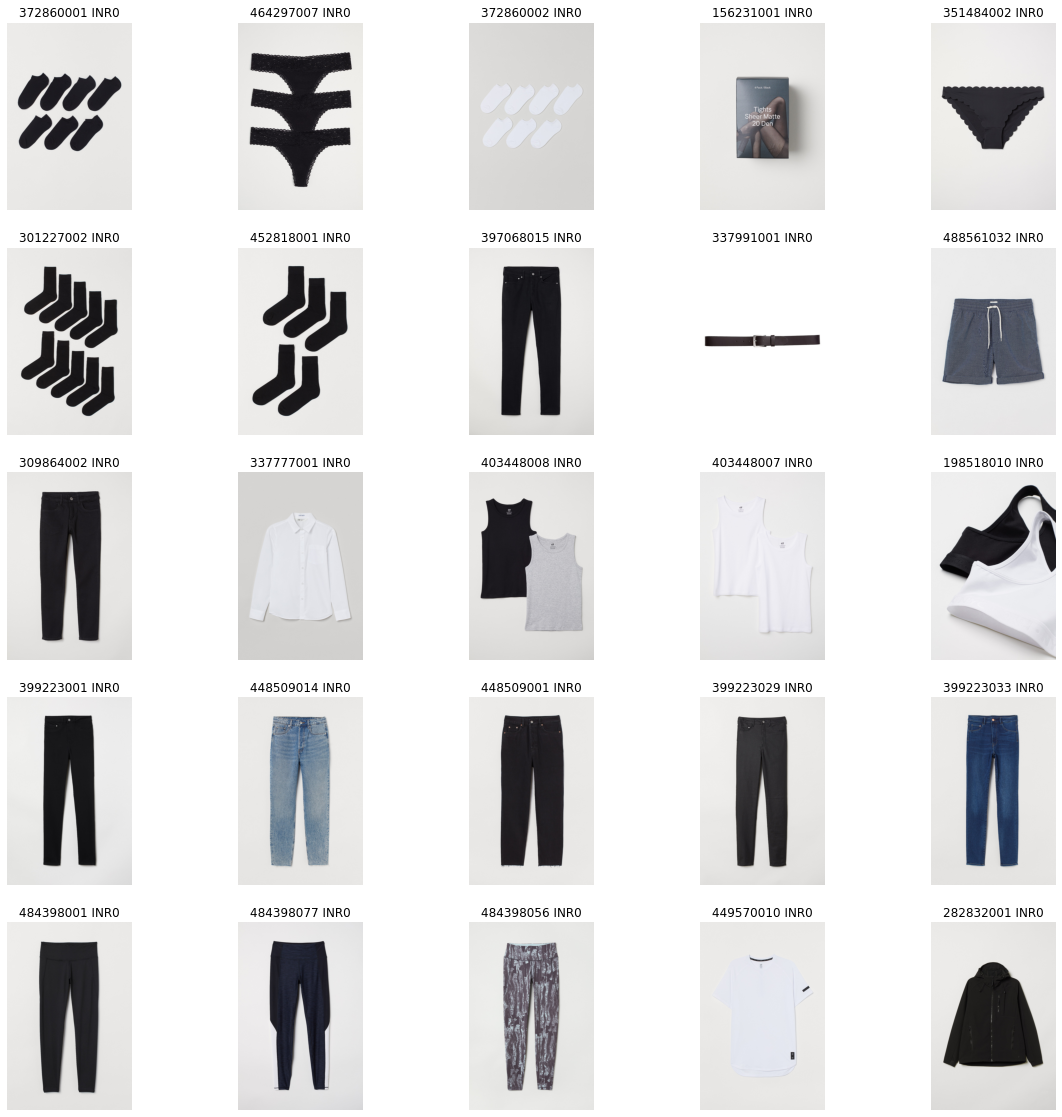

282832001

In [95]:
display_popular()

**ALL MERGED**

In [96]:
existing_customer=list(customers_final)

In [97]:
def recommend(cust_id):
    a=input('enter `proceed` or `search` :')
    if(a=='search'):
        print('Let US Know the product that you are looking for:')
        selective('yes')
    elif(a=='proceed'):
        cust_type=[]
        if(cust_id in existing_customer):
            print('Welcome Back Customer Name')
            cust_type.append('old_cust')
            print('personalised Recommendations')
            index_pos=test_data[test_data['customer_id']==cust_id].index.values
            arts=test_data.iloc[index_pos[0],1]
            print(arts)
            products=[]
            items=[]
            for a in arts:
                art_index=articles[articles.article_id==a].index.values
                products.append(articles.at[art_index[0],'product_type_name'])
                items.append(a)
            print(items)
            unique_items=pd.DataFrame()
            unique_items['products']=pd.Series(products)
            unique_items['article_ids']=pd.Series(items)
            unique_products=unique_items.groupby('products')['article_ids'].agg(list).reset_index()
            print(unique_products.head())
            final_list=[]
            for i,j in zip(unique_products['products'],unique_products['article_ids']):
                arts_list=[]
                for x in j:
                    arts_list.append(str(x))
                final_list.append(arts_list[0])
            print(final_list)
            print(final_list)
            for ids in final_list:
                idd = str(ids)
                path = f"images/0{idd[0:2]}/0{idd}.jpg"
                img = mpimg.imread(path)
                imgplot = plt.imshow(img)
                plt.axis('off')
                plt.show()
                similar_items = list(item_similarities[item_similarities['item']==int(idd)]['similar_items'])[0]
                _,ax = plt.subplots(1,len(similar_items),figsize=(15,10))
                for i,x in enumerate(similar_items):
                    id = str(x)
                    price=transactions[transactions['article_id']==x]['price'].to_list()
                    price=mean(price)
                    price=int(price)
                    path = f"images/0{id[0:2]}/0{id}.jpg"
                    img = mpimg.imread(path)
                    ax[i].imshow(img)
                    ax[i].axis('off')
                    ax[i].set_title(str(id+'  '+'INR'+str(price)))
                plt.show()
            print('customer clicked a image')
            retrieve_most_similar_products(similar_items[1])
        elif(cust_id not in existing_customer):
            print('Welcome To H&M')
            cust_type.append('new_cust')
            display_popular()
            print('customer clicked a image')
            retrieve_most_similar_products(554598001)
        

In [98]:
existing_customer[0]

'00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657'

enter `proceed` or `search` :search
Let US Know the product that you are looking for:
shirt


<Figure size 432x288 with 0 Axes>

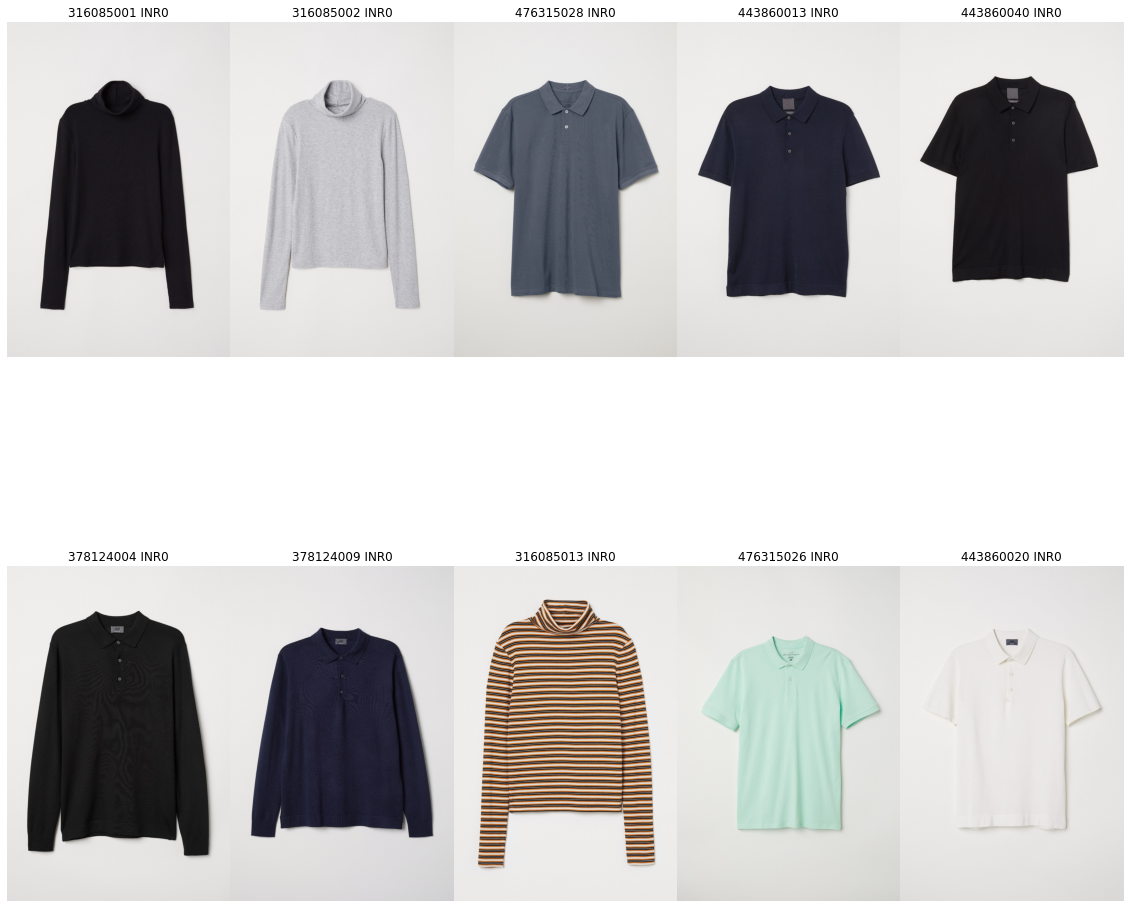

In [102]:
recommend(existing_customer[1])